In [1]:
from dctkit.dec import cochain as C
from dctkit.mesh.simplex import SimplicialComplex
from dctkit.mesh.util import generate_line_mesh, build_complex_from_mesh
from dctkit.math.opt import optctrl as oc
import matplotlib.pyplot as plt
from deap import gp
from alpine.gp import gpsymbreg as gps
from dctkit import config
import dctkit
import numpy as np
import ray
import math
import yaml
from typing import Tuple, Callable, List
import numpy.typing as npt

[nexus7:39518] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


In [2]:
# choose precision and whether to use GPU or CPU
# needed for context of the plots at the end of the evolution
config()

def eval_MSE_sol(residual: Callable, X: npt.NDArray, y: npt.NDArray,
             S: SimplicialComplex, u_0: C.CochainP0) -> float:

    num_nodes = X.shape[1]

    # need to call config again before using JAX in energy evaluations to make sure that
    # the current worker has initialized JAX
    config()

    # objective: squared norm of the residual of the equation + penalty on Dirichlet 
    # boundary condition on the first node
    def obj(x, y):
        penalty = 100.*x[0]**2
        u = C.CochainP0(S, x)
        f = C.CochainP0(S, y)
        r = residual(u, f)
        total_energy = C.inner_product(r, r) + penalty
        return total_energy

    prb = oc.OptimizationProblem(dim=num_nodes, state_dim=num_nodes, objfun=obj)

    total_err = 0.

    best_sols = []

    for i, vec_y in enumerate(y):
        # set additional arguments of the objective function (apart from the vector of unknowns)
        args = {'y': vec_y}
        prb.set_obj_args(args)

        # minimize the objective
        x = prb.solve(x0=u_0.coeffs, ftol_abs=1e-12, ftol_rel=1e-12, maxeval=1000)

        if (prb.last_opt_result == 1 or prb.last_opt_result == 3
                or prb.last_opt_result == 4):

            current_err = np.linalg.norm(x-X[i, :])**2
        else:
            current_err = math.nan

        if math.isnan(current_err):
            total_err = 1e5
            break

        total_err += current_err

        best_sols.append(x)

    total_err *= 1/X.shape[0]

    return total_err, best_sols

In [3]:
@ray.remote
def eval_sols(individual: Callable, indlen: int, X: npt.NDArray, y: npt.NDArray,
            S: SimplicialComplex, u_0: C.CochainP0, penalty: dict) -> List[npt.NDArray]:

    _, best_sols = eval_MSE_sol(individual, X, y, S, u_0)

    return best_sols

In [4]:
@ray.remote
def eval_fitness(individual: Callable, indlen: int, X: npt.NDArray, y: npt.NDArray,
                 S: SimplicialComplex, u_0: C.CochainP0, penalty: dict) -> Tuple[float, ]:

    total_err, _ = eval_MSE_sol(individual, X, y, S, u_0)

    # add penalty on length of the tree to promote simpler solutions
    objval = total_err + penalty["reg_param"]*indlen

    return objval,

In [5]:
def stgp_poisson():
    with open("ex1.yaml") as config_file:
        config_file_data = yaml.safe_load(config_file)

    # generate mesh and dataset
    mesh, _ = generate_line_mesh(num_nodes=11, L=1.)
    S = build_complex_from_mesh(mesh)
    S.get_hodge_star()
    x = S.node_coords 
    num_nodes = S.num_nodes

    # generate training and test datasets
    # exact solution = x² 
    u = C.CochainP0(S, np.array(x[:,0]**2, dtype=dctkit.float_dtype))
    # compute source term such that u solves the discrete Poisson equation 
    # Delta u + f = 0, where Delta is the discrete Laplace-de Rham operator
    f = C.laplacian(u)
    f.coeffs *= -1.
    X_train = np.array([u.coeffs],dtype=dctkit.float_dtype)
    y_train = np.array([f.coeffs], dtype=dctkit.float_dtype)

    # initial guess for the unknown of the Poisson problem (cochain of nodals values)
    u_0_vec = np.zeros(num_nodes, dtype=dctkit.float_dtype)
    u_0 = C.CochainP0(S, u_0_vec)

    # define primitive set for the residual of the discrete Poisson equation
    pset = gp.PrimitiveSetTyped("RESIDUAL", [C.CochainP0, C.CochainP0], C.CochainP0)

    # rename arguments of the residual
    pset.renameArguments(ARG0="u")
    pset.renameArguments(ARG1="f")

    GPprb = gps.GPSymbRegProblem(pset=pset, config_file_data=config_file_data)

    penalty = config_file_data["gp"]["penalty"]

    # store shared objects refs

    GPprb.store_eval_common_params({'S': S, 'u_0': u_0, 'penalty': penalty})
    param_names = ('X', 'y')
    datasets = {'train': [X_train, y_train], 'test': [X_train, y_train]}

    GPprb.store_eval_dataset_params(param_names, datasets)

    GPprb.register_eval_funcs(fitness=eval_fitness.remote, test_sols=eval_sols.remote)

    feature_extractors = [len] 
    GPprb.register_map(feature_extractors)

    GPprb.run(print_log=True, plot_best_individual_tree=False)

    u_best = GPprb.toolbox.map(GPprb.toolbox.evaluate_test_sols, (GPprb.best,))[0]

    ray.shutdown()
    plt.figure()
    plt.plot(x[:,0], u.coeffs)
    plt.plot(x[:,0], np.ravel(u_best), "ro")
    plt.show()


2024-02-12 14:54:22,288	INFO worker.py:1724 -- Started a local Ray instance.


> MODEL TRAINING/SELECTION STARTED
Generating initial population...
DONE.
 -= START OF EVOLUTION =- 
Evaluating initial population...


(pid=44718) [nexus7:44718] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
(eval_fitness pid=44718) 2024-02-12 14:54:23.520698: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:273] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
(eval_fitness pid=44718) CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


DONE.
   	     	           fitness           	             size             
   	     	-----------------------------	------------------------------
gen	evals	min   	avg   	max   	std  	min	avg 	max	std   
1  	100  	2.7577	2.9185	3.2333	0.114	3  	3.93	10 	1.2826
The best individual of this generation is: delP1(AddCP1(MFP1(cobP0(u), InnP0(f, f)), cobP0(f)))
2  	100  	2.7577	2.8325	2.8333	0.0075	3  	3.07	10 	0.6965
The best individual of this generation is: delP1(AddCP1(MFP1(cobP0(u), InnP0(f, f)), cobP0(f)))
3  	100  	2.7577	2.8325	2.8333	0.0075	3  	3.07	10 	0.6965
The best individual of this generation is: delP1(AddCP1(MFP1(cobP0(u), InnP0(f, f)), cobP0(f)))
4  	100  	2.7577	2.8318	2.8333	0.0106	3  	3.14	10 	0.98  
The best individual of this generation is: delP1(AddCP1(MFP1(cobP0(u), InnP0(f, f)), cobP0(f)))
5  	100  	2.7577	2.831 	2.8333	0.0129	3  	3.21	10 	1.1941
The best individual of this generation is: delP1(AddCP1(MFP1(cobP0(u), InnP0(f, f)), cobP0(f)))
6  	100  	0.7327	2.8093	2.

(pid=44695) [nexus7:44695] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored) [repeated 23x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/ray-logging.html#log-deduplication for more options.)
(eval_fitness pid=44706) 2024-02-12 14:54:23.873825: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:273] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected [repeated 23x across cluster]
(eval_fitness pid=44706) CUDA backend failed to initialize: FAILED_PRECONDITION: No visible GPU devices. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.) [repeated 23x across cluster]


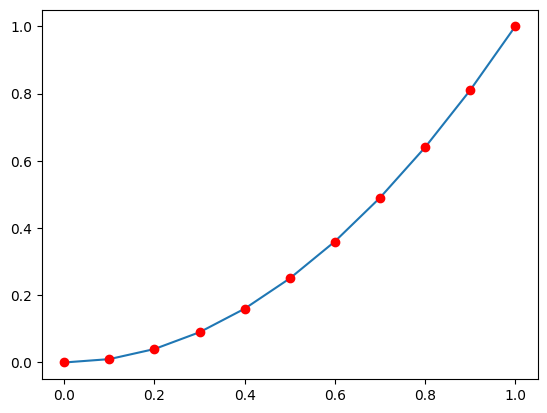

In [15]:
ray.shutdown()
stgp_poisson()
